In [1]:
import os
import timm
import torch

import warnings
warnings.filterwarnings("ignore")

# Timm Model Factory

You can use the `TimmModelFactory` to initialize classification tasks in TerraTorch.

In [2]:
# Lets look for pre-trained ViT models
print(timm.list_pretrained("*vit*"))

['convit_base.fb_in1k', 'convit_small.fb_in1k', 'convit_tiny.fb_in1k', 'crossvit_9_240.in1k', 'crossvit_9_dagger_240.in1k', 'crossvit_15_240.in1k', 'crossvit_15_dagger_240.in1k', 'crossvit_15_dagger_408.in1k', 'crossvit_18_240.in1k', 'crossvit_18_dagger_240.in1k', 'crossvit_18_dagger_408.in1k', 'crossvit_base_240.in1k', 'crossvit_small_240.in1k', 'crossvit_tiny_240.in1k', 'davit_base.msft_in1k', 'davit_small.msft_in1k', 'davit_tiny.msft_in1k', 'flexivit_base.300ep_in1k', 'flexivit_base.300ep_in21k', 'flexivit_base.600ep_in1k', 'flexivit_base.1000ep_in21k', 'flexivit_base.1200ep_in1k', 'flexivit_base.patch16_in21k', 'flexivit_base.patch30_in21k', 'flexivit_large.300ep_in1k', 'flexivit_large.600ep_in1k', 'flexivit_large.1200ep_in1k', 'flexivit_small.300ep_in1k', 'flexivit_small.600ep_in1k', 'flexivit_small.1200ep_in1k', 'gcvit_base.in1k', 'gcvit_small.in1k', 'gcvit_tiny.in1k', 'gcvit_xtiny.in1k', 'gcvit_xxtiny.in1k', 'levit_128.fb_dist_in1k', 'levit_128s.fb_dist_in1k', 'levit_192.fb_dist

In [3]:
# instantiate SAM model
model = timm.create_model(
    "vit_base_patch16_224.mae", pretrained=True, num_classes=0, in_chans=6,
)

In [4]:
from terratorch.models import TimmModelFactory

# Let's build a classification model using timm
model = TimmModelFactory().build_model(
    task="classification",
    backbone="vit_base_patch16_224.mae",
    in_channels=6,
    num_classes=12,
    pretrained=True,
)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.mae)
INFO:timm.models._hub:[timm/vit_base_patch16_224.mae] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv patch_embed.proj pretrained weights from 3 to 6 channel(s)


In [5]:
# Running a test with the model 
trial_data = torch.zeros(2, 6, 224, 224) # batch_size, channels, height, width
output = model(trial_data)
print(f"Features has shape {output.output.shape}")

Features has shape torch.Size([2, 12])


# Datamodule
You can create datamodules for training by leveraging one of our generic data modules. Alternatively, creating your own subclasses of `torchgeo.datamodules.GeoDataModule` or `torchgeo.datamodules.NonGeoDataModule`.

Datamodules package train, test and validation datasets as well as any transforms done.

Any [TorchGeo](https://torchgeo.readthedocs.io/en/stable/) datamodule will also be compatible with TerraTorch.

## Example

Let's use the burn scar segmentation dataset as an example (https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars).

In [6]:
DATASET_PATH = os.path.join('data', 'ForestNetDataset')

# Make sure the dataset is ready
assert os.path.isdir(os.path.join(DATASET_PATH, 'val')), ("Please download and preprocess the dataset folloing the code in "
                                                          "https://github.com/stemauro/gfm-workshop/blob/main/datasets/preprocess_forestnet.py")

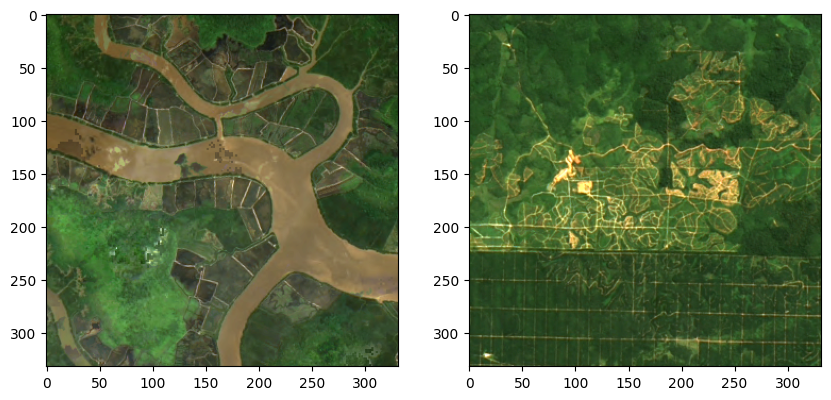

In [19]:
# Lets visualize the data
import matplotlib.pyplot as plt
import rioxarray as rxr

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(rxr.open_rasterio('data/ForestNetDataset/train/Fish pond/train_153.tif').sel(band=[3, 2, 1]).transpose("y", "x", "band").to_numpy() * 3)
ax[1].imshow(rxr.open_rasterio('data/ForestNetDataset/train/Oil palm plantation/train_9.tif').sel(band=[3, 2, 1]).transpose("y", "x", "band").to_numpy() * 3)
plt.show()

In [28]:
from terratorch.datamodules import GenericNonGeoClassificationDataModule
from terratorch.datasets import HLSBands
import albumentations
 
# HLS Pre-traning statistics
means = [
    775.229,
    1080.992,
    1228.585,
    2497.202,
    2204.213,
    1610.832
]
stds = [
    1281.526,
    1270.029,
    1399.480,
    1368.344,
    1291.676,
    1154.505
]
hls_bands = [
    HLSBands.BLUE,
    HLSBands.GREEN,
    HLSBands.RED,
    HLSBands.NIR_NARROW,
    HLSBands.SWIR_1,
    HLSBands.SWIR_2,
]
# For 3 channel RGB models, you might want to use the ImageNet values: 
# mean = [0.485, 0.456, 0.406]
# stds = [0.229, 0.224, 0.225]

# Timm requires 224x224 input.
train_transforms = albumentations.Compose([
    albumentations.RandomCrop(height=224, width=224),
    albumentations.HorizontalFlip(),
    albumentations.pytorch.transforms.ToTensorV2(),
])
val_transforms = albumentations.Compose([
    albumentations.CenterCrop(height=224, width=224),
    albumentations.pytorch.transforms.ToTensorV2(),
])

datamodule = GenericNonGeoClassificationDataModule(
    batch_size=16,
    num_workers=0,
    train_data_root=os.path.join(DATASET_PATH, 'train'),
    val_data_root=os.path.join(DATASET_PATH, 'val'),
    test_data_root=os.path.join(DATASET_PATH, 'test'), 
    means=means,
    stds=stds,
    num_classes=12,

    # if transforms are defined with Albumentations, you can pass them here
    train_transform=train_transforms,
    val_transform=val_transforms,
    test_transform=val_transforms,

    # Bands of your dataset (in this case similar to the model bands)
    dataset_bands=hls_bands,
    # Input bands of your model
    output_bands=hls_bands,
    constant_scale=39.216,  # Scale 0-255 data to 0-10000 (HLS data) (10000 / 255 = 39.216)
    no_data_replace=0,
)
# we want to access some properties of the train dataset later on, so lets call setup here
# if not, we would not need to
datamodule.setup("fit")

# Lightning Trainers
At the highest level of abstraction, you can operate with task specific trainers. These encapsulate the model, loss, optimizer and any training hyperparameters.

They build on the model factory we introduced previously and are able to take any. To use a task with a model not supported by a currently existing model factory, simply create your own model factory!

Let's create a Trainer for Semantic Segmentation.

In [29]:
from terratorch.tasks import ClassificationTask

model_args = {
        "backbone": "vit_base_patch16_224.mae", # see timm.list_pretrained() 
        "in_channels": 6,
        "num_classes": 12,
        "pretrained": True,
}

task = ClassificationTask(
    model_args=model_args,
    model_factory="TimmModelFactory",
    loss="ce",
    lr=1e-4,
    ignore_index=-1,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    freeze_backbone=True
)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.mae)
INFO:timm.models._hub:[timm/vit_base_patch16_224.mae] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv patch_embed.proj pretrained weights from 3 to 6 channel(s)


In [30]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=20)
logger = TensorBoardLogger(save_dir='output', name='tutorial')

# You can also log directly to WandB
# from lightning.pytorch.loggers import WandbLogger
# wandb_logger = WandbLogger(log_model="all") 

trainer = Trainer(
    devices=1, # Number of GPUs. Interactive mode recommended with 1 device
    precision="16-mixed",
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        early_stopping_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=logger,
    max_epochs=1, # train only one epoch for demo
    default_root_dir='output/tutorial',
    log_every_n_steps=1,
    check_val_every_n_epoch=1
)
_ = trainer.fit(model=task, datamodule=datamodule)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (mps), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ TimmModelWrapper │ 86.4 M │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │
│ 2 │ train_metrics │ MetricCollection │      0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 9.2 K                                                                                            
Non-trainable params: 86.4 M                                                                                       
Total params: 86.4 M                                                                                               
Total estimated model params size (MB): 345

Output()

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [31]:
res = trainer.test(model=task, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/Average_Accuracy      │       0.0833333358168602       │
│    test/Multiclass_F1_Score    │      0.20958083868026733       │
│ test/Multiclass_Jaccard_Index  │      0.017465069890022278      │
│     test/Overall_Accuracy      │      0.20958083868026733       │
│           test/loss            │       2.2181930541992188       │
│   test/multiclassaccuracy_0    │              0.0               │
│   test/multiclassaccuracy_1    │              0.0               │
│   test/multiclassaccuracy_10   │              0.0               │
│   test/multiclassaccuracy_11   │              0.0               │
│   test/multiclassaccuracy_2    │              0.0               │
│   test/multiclassaccuracy_3    │              0.0               │
│   test/multiclassaccuracy_4    │              0.0               │
│   test/multiclassaccuracy_5    │              0.0               │
│   test/multiclassaccuracy_6    │              0.0               │
│   test/multiclassaccuracy_7    │              0.0               │
│   test/multiclassaccuracy_8    │              1.0               │
│   test/multiclassaccuracy_9    │              0.0               │
│ test/multiclassjaccardindex_0  │              0.0               │
│ test/multiclassjaccardindex_1  │              0.0               │
│ test/multiclassjaccardindex_10 │              0.0               │
│ test/multiclassjaccardindex_11 │              0.0               │
│ test/multiclassjaccardindex_2  │              0.0               │
│ test/multiclassjaccardindex_3  │              0.0               │
│ test/multiclassjaccardindex_4  │              0.0               │
│ test/multiclassjaccardindex_5  │              0.0               │
│ test/multiclassjaccardindex_6  │              0.0               │
│ test/multiclassjaccardindex_7  │              0.0               │
│ test/multiclassjaccardindex_8  │      0.20958083868026733       │
│ test/multiclassjaccardindex_9  │              0.0               │
└────────────────────────────────┴────────────────────────────────┘

In [49]:
# Analyze training in tensorboard
!tensorboard --logdir output/ --port 9010  # add --host $(hostname -f) for clusters

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.17.1 at http://Thornhill:9010/ (Press CTRL+C to quit)
^C


# CLI tool

You find an example for SMP models in `examples/confs/forestnet_timm.yaml` that you can run with `terratorch fit -c examples/confs/forestnet_timm.yaml`. 